# Chapter 5 - Indoor Scene Classification with TFLu and the Arduino Nano

In [1]:
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


### Python libraries

In [2]:
import numpy as np
import pathlib
#!export PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python
import tensorflow as tf
#import tensorflow_datasets as tfds
import zipfile
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
# from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

2023-07-06 18:00:03.198630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 18:00:03.605095: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-06 18:00:03.605143: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-06 18:00:04.979054: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

### Constants

In [3]:
MODEL_ALPHA = 0.35
MODEL_INPUT_WIDTH = 48
MODEL_INPUT_HEIGHT = 48
TFL_MODEL_FILE = "temp.tflite"
TFL_MODEL_HEADER_FILE = "temp_model.h"
TF_MODEL = "temp"

## Transfer learning with Keras

### Unzip the dataset (dataset.zip) SKIP THIS STEP


In [4]:
# with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
#   zip_ref.extractall(".")
# data_dir = "dataset"

### Prepare the train (80%) and validation (20%) datasets

In [5]:
data_dir="datasetv2v1hq"
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  interpolation="bilinear",
  image_size=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT)
  )

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  interpolation="bilinear",
  image_size=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT)
  )

Found 135 files belonging to 3 classes.
Using 108 files for training.
Found 135 files belonging to 3 classes.
Using 27 files for validation.


2023-07-06 18:00:08.212071: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-06 18:00:08.212546: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-07-06 18:00:08.212609: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-07-06 18:00:08.212695: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-07-06 18:00:08.212764: W tensorfl

### Get the name of the classes

In [6]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['paper', 'rock', 'scissors']


### Rescale the pixel values from [0, 255] to [-1, 1]

In [7]:
rescale = tf.keras.layers.Rescaling(1./255, offset= -1)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
val_ds   = val_ds.map(lambda x, y: (rescale(x), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### Import the MobileNet v2 pre-trained model

In [8]:
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet_v2.py
base_model = MobileNetV2(input_shape=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT, 3),
                         include_top=False,
                         weights='imagenet',
                         alpha=0.35)
base_model.trainable = False

feat_extr = base_model

### Augment the input data

In [9]:
augmen = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  #tf.keras.layers.experimental.preprocessing.RandomZoom(0.1, 0.1),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)
])

train_ds = train_ds.map(lambda x, y: (augmen(x), y))
val_ds   = val_ds.map(lambda x, y: (augmen(x), y))

### Prepare the classification head

In [10]:
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

### Build the model architecture

In [11]:
inputs = tf.keras.Input(shape=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT, 3))
x = global_avg_layer(feat_extr.layers[-1].output)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = dense_layer(x)
model = tf.keras.Model(inputs=feat_extr.inputs, outputs=outputs)

### Compile the model with a 0.0005 learning rate

In [12]:
lr = 0.0005
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

### Model summary

In [13]:
# model.summary()

### Train the model with 10 epochs

In [14]:
history=model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)

Epoch 1/50
4/4 [==============================] - 4s 600ms/step - loss: 1.6905 - accuracy: 0.3704 - val_loss: 1.6177 - val_accuracy: 0.2222
Epoch 2/50
4/4 [==============================] - 1s 379ms/step - loss: 1.4050 - accuracy: 0.3519 - val_loss: 1.4578 - val_accuracy: 0.1852
Epoch 3/50
4/4 [==============================] - 1s 411ms/step - loss: 1.4294 - accuracy: 0.3889 - val_loss: 1.2575 - val_accuracy: 0.4815
Epoch 4/50
4/4 [==============================] - 1s 402ms/step - loss: 1.4089 - accuracy: 0.3796 - val_loss: 1.1732 - val_accuracy: 0.4444
Epoch 5/50
4/4 [==============================] - 1s 388ms/step - loss: 1.1845 - accuracy: 0.4352 - val_loss: 1.1009 - val_accuracy: 0.5185
Epoch 6/50
4/4 [==============================] - 1s 358ms/step - loss: 1.1758 - accuracy: 0.4444 - val_loss: 1.0753 - val_accuracy: 0.4815
Epoch 7/50
4/4 [==============================] - 1s 357ms/step - loss: 1.1690 - accuracy: 0.4537 - val_loss: 1.0719 - val_accuracy: 0.5185
Epoch 8/50
4/4 [====

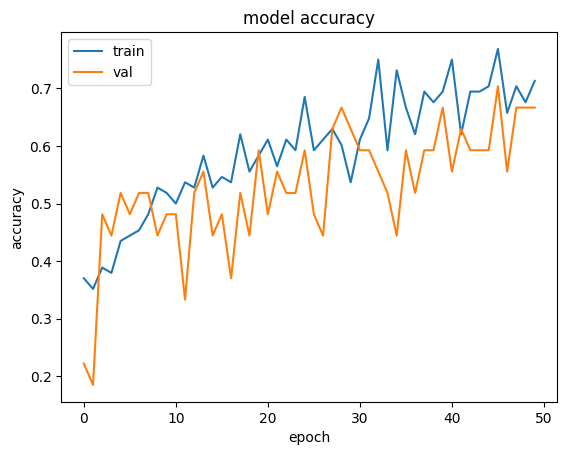

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

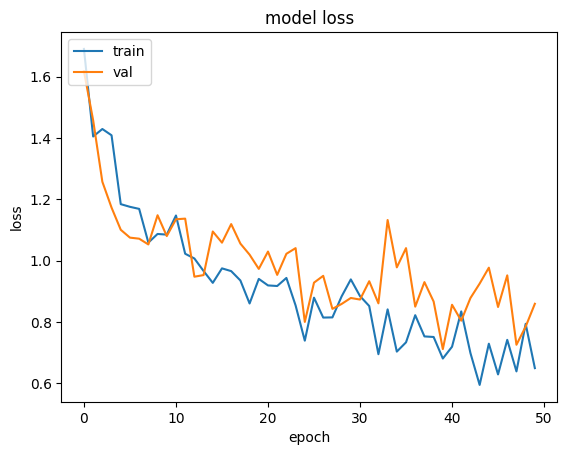

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Save the TensorFlow model

In [17]:
model.save(TF_MODEL)

INFO:tensorflow:Assets written to: temp/assets


INFO:tensorflow:Assets written to: temp/assets


## Preparing and testing the quantized TFLite model

### Unzip the test dataset (test_samples.zip)

In [18]:
# with zipfile.ZipFile("test_samples.zip", 'r') as zip_ref:
#     zip_ref.extractall(".")
# test_dir = "dataset"

### Rescale the pixel values from [0, 255] to [-1, 1]

In [19]:
test_dir="datasetv2v1hq"
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                      interpolation="bilinear",
                                                      image_size=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT))
test_ds  = test_ds.map(lambda x, y: (rescale(x), y))

Found 135 files belonging to 3 classes.


### Quantize the TensorFlow model with the TFLite converter

In [20]:
repr_ds = test_ds.unbatch()

def representative_data_gen():
  for i_value, o_value in repr_ds.batch(1).take(48):
    yield [i_value]

converter = tf.lite.TFLiteConverter.from_saved_model(TF_MODEL)
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8

tfl_model = converter.convert()

2023-07-06 18:06:11.105684: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-07-06 18:06:11.106089: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-07-06 18:06:11.135705: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: temp
2023-07-06 18:06:11.209854: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-07-06 18:06:11.210083: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: temp
2023-07-06 18:06:11.361553: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-07-06 18:06:13.987240: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: F

### Get the TFLite model size in bytes

In [21]:
size_tfl_model = len(tfl_model)
print(len(tfl_model), "bytes")

618664 bytes


### Initialize the TFLite interpreter

In [22]:
# Initialize the TFLite interpreter
interpreter = tf.lite.Interpreter(model_content=tfl_model)

# Allocate the tensors
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### Get input quantization parameters

In [23]:
# Get input/output layer information
i_details = interpreter.get_input_details()[0]
o_details = interpreter.get_output_details()[0]

# Get input quantization parameters.
i_quant = i_details["quantization_parameters"]
i_scale      = i_quant['scales'][0]
i_zero_point = i_quant['zero_points'][0]

### Evaluate the accuracy of the quantized TFLite model

In [24]:
test_ds0 = val_ds.unbatch()

num_correct_samples = 0
num_total_samples   = len(list(test_ds0.batch(1)))

for i_value, o_value in test_ds0.batch(1):
  i_value = (i_value / i_scale) + i_zero_point
  i_value = tf.cast(i_value, dtype=tf.int8)
  interpreter.set_tensor(i_details["index"], i_value)
  interpreter.invoke()
  o_pred = interpreter.get_tensor(o_details["index"])[0]

  if np.argmax(o_pred) == o_value:
    num_correct_samples += 1

print("Accuracy:", num_correct_samples/num_total_samples)

Accuracy: 0.4074074074074074


### Convert the TFLite model to C-byte array with xxd

In [25]:
open("model.tflite", "wb").write(tfl_model)
!apt-get update && apt-get -qq install xxd
!xxd -c 60 -i model.tflite > modelv5.cpp

Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
